# How Data Can Allow Us to Predict a Starbucks Customer's Response to an Offer
Anyone who knows me will be able to tell you that I have an unhealthy obsession with Starbucks. In fact, I’m writing this blog at a Starbucks Reserve — 15 miles away from my apartment, mind you — with a London Fog in hand. Why, then, do I decide to make the commute to work here every day instead of one of the countless coffee shops within walking distance? I’m not picky about coffee quality, so that doesn’t matter to me. And wifi is available pretty much anywhere nowadays. Why am I addicted to Starbucks then? Simple. The perks. Starbucks notoriously lures customers in with their star system, where customers will be rewarded with stars whenever they make a purchase, which can be used towards a free item in the future. Even more, Starbucks has been advertising offers, where customers can receive bonus stars, get a free drink with the purchase of one drink, and score major discounts!

In this notebook, you'll find that I've done the following:

1. I decided to perform an analysis on some data provided by Starbucks.

Some questions that I’m trying to answer:

Which age group took the most advantage of the offers?
Of the age group(s) that completed offers, which offers did they take most advantage of?
How many males vs females took action on offers?
What channels are most likely to lead customers to complete offers?
Are customers influenced by the minimum spend requirement of an offer, or even by the offer amount? Do either of these metrics affect the likelihood that they will use an offer?

2. I created four machine learning models that can predict whether or not a Starbucks customer will accept an offer.

Classifiers Used:

Random Forest Classifier
Decision Tree Classifier
KNN Classifier
To refine the RFC model, I additionally employed a Grid Search CV approach

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.metrics import mean_squared_error, fbeta_score, accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from time import time
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

from datetime import datetime

import seaborn as sns
% matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

Let's start by gathering some quick stats on each of the datasets from Starbucks

## 1. Profile Dataset

In [3]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


Okay, so it looks like "gender" and "income" have missing values. Let's calculate the percentage of null values for each of these columns so we can determine if imputing the null values is appropriate. Usually, we'll impute if at least 70% of the rows are populated, otherwise we can just remove it as a feature

In [5]:
print("The Income column has: " + str(((len(profile) - profile.income.count())/ len(profile)) * 100)  + "% null values")

The Income column has: 12.7941176471% null values


In [6]:
print("The gender column has: " + str(((len(profile) - profile.gender.count())/ len(profile)) * 100)  + "% null values")

The gender column has: 12.7941176471% null values


Okay, not too bad. We can definitely use these columns as features, but we'll need to deal with the missing values a bit later

In [7]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


Let's take a look at the age distribution

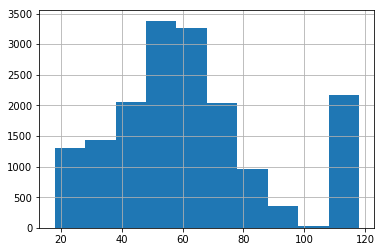

In [8]:
profile.age.hist();

We see a clear outlier here at the age of 118. We'll need to look deeper into that later

Looks like we also have a significant age range in our data. We might want to categorize these customers to reduce noise during modeling

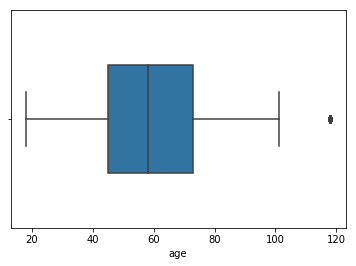

In [9]:
sns.boxplot(profile['age'], width=0.5);

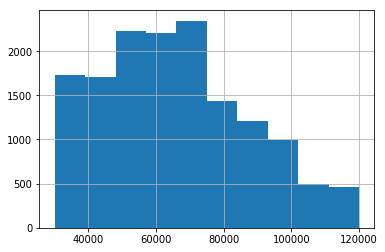

In [10]:
# income distribution
profile.income.hist();

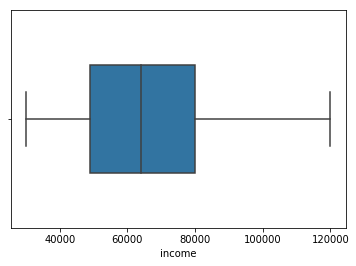

In [11]:
sns.boxplot(profile['income'], width=0.5);

no crazy outliers to take note of here

## 2. Portfolio Dataset

In [12]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


Unclear what duration and difficulty columns refer to

In [13]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


no null values here!

In [14]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


## 3. Transcript Dataset

In [15]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


This dataset is a little messier than the others. We're going to have to pre-process the value field later so that we can join this dataset with the others

In [16]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [17]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


Looks like this dataset also doesn't have any null values!

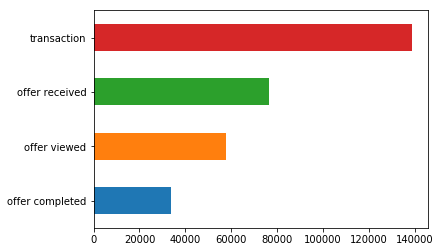

In [18]:
# event distribution
transcript.event.value_counts().sort_values().plot(kind = 'barh')

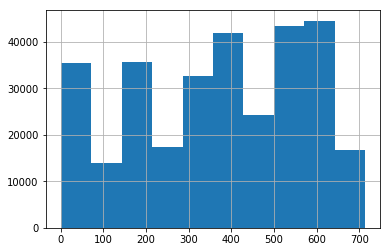

In [19]:
transcript.time.hist();

# Data Cleanup + Pre-processing

Let's start with some cleanup

## 1. Profile Dataset

In [20]:
profile_copy=profile.copy()

In [21]:
profile_copy.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [22]:
# rename columns
new_col_names = {'id':'customer_id' , 'income':'customer_income', 'gender':'customer_gender', 'age': 'customer_age'}
profile_copy = profile_copy.rename(new_col_names, axis=1)

Let's start by changing the format of the "became_member_on" field. it's a bit hard to read

In [23]:
profile_copy['became_member_on'] = pd.to_datetime(profile_copy['became_member_on'], format='%Y%m%d')
profile_copy['became_member_on'].head(1)

0   2017-02-12
Name: became_member_on, dtype: datetime64[ns]

In [24]:
#check for different age values
profile_copy.customer_age.value_counts()

118    2175
58      408
53      372
51      363
54      359
59      359
57      353
52      351
55      350
56      342
63      338
60      333
49      321
62      318
67      317
64      311
61      309
48      288
50      284
66      284
65      280
68      259
70      252
69      242
47      232
45      231
71      230
42      227
43      215
46      212
       ... 
22      131
30      131
29      129
23      126
81      118
35      118
79      117
80      116
31      113
82      105
83      102
84       83
18       70
85       70
87       66
88       64
86       54
89       53
90       52
91       47
92       40
94       33
93       29
95       22
97       13
100      12
96        8
98        5
99        5
101       5
Name: customer_age, Length: 85, dtype: int64

weird...there's a lot of people who are 118 years old... perhaps 
According to the description of the profile data frame and checking null values, it looks like values of gender & income are missing where age is 118. Let's confirm this.

In [25]:
profile_copy[profile_copy['customer_age']== 118].drop(['became_member_on' ,'customer_id'], axis=1)

,customer_age,customer_gender,customer_income
0,118,None,NaN
2,118,None,NaN
4,118,None,NaN
6,118,None,NaN
7,118,None,NaN
9,118,None,NaN
10,118,None,NaN
11,118,None,NaN
17,118,None,NaN
23,118,None,NaN


Suspicion was correct....Let's replace these ages with NULL and then impute the null ages with the mean age. Using the mean age will be a little more expressive

In [26]:
profile_copy.replace(118, np.nan , inplace=True)
profile_copy['customer_age'] = profile_copy['customer_age'].fillna(profile_copy['customer_age'].mean())

Since we also observed null values for customer income, let's impute the missing values with the income mean

In [27]:
profile_copy['customer_income'] = profile_copy['customer_income'].fillna(profile_copy['customer_income'].mean())

What should we do with the null genders? The most sensible thing to do would be to impute those values with the mode

In [28]:
mode = profile_copy['customer_gender'].mode()[0]
profile_copy['customer_gender'] = profile_copy['customer_gender'].fillna(mode)
profile_copy['customer_gender'] = profile_copy['customer_gender'].replace('O', mode)

Let's take a look at the age distribution again

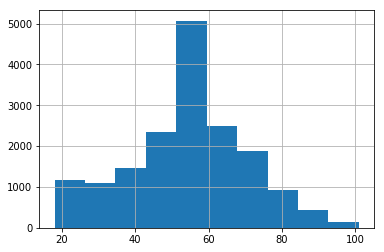

In [29]:
profile_copy.customer_age.hist();

As aforementioned, we have a large age range, so let's bucketize these ages into categories to reduce noise during the learning process

In [30]:
profile_copy.loc[(profile_copy.customer_age < 20) , 'Age_Group'] = 'Under 20'
profile_copy.loc[(profile_copy.customer_age >= 20) & (profile_copy.customer_age <= 45) , 'Age_Group'] = '20-45'
profile_copy.loc[(profile_copy.customer_age >= 46) & (profile_copy.customer_age <= 60) , 'Age_Group'] = '46-60'
profile_copy.loc[(profile_copy.customer_age >= 61) , 'Age_Group'] = '61-80'
profile_copy.drop('customer_age',axis=1,inplace=True)

In [31]:
cleaned_profile = profile_copy

## 2. Portfolio Dataset

In [32]:
portfolio_copy = portfolio.copy(deep=True)
portfolio_copy.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [33]:
#rename columns
new_col_names = {'difficulty':'offer_difficulty' , 'id':'offer_id', 'duration':'offer_duration', 'reward': 'offer_reward'}
portfolio_copy = portfolio_copy.rename(new_col_names, axis=1)

In [34]:
channels_exploded = pd.get_dummies(portfolio_copy['channels'].apply(pd.Series).stack()).sum(level=0)

In [35]:
portfolio_copy = pd.concat([portfolio_copy, channels_exploded], axis=1)

portfolio_copy.head()

,channels,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward,email,mobile,social,web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [36]:
offer_type_exploded = pd.get_dummies(portfolio_copy['offer_type'].apply(pd.Series).stack()).sum(level=0)
offer_type_exploded.head()

,bogo,discount,informational
0,1,0,0
1,1,0,0
2,0,0,1
3,1,0,0
4,0,1,0


In [37]:
portfolio_copy = pd.concat([portfolio_copy, offer_type_exploded], axis=1)

portfolio_copy.head()

,channels,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward,email,mobile,social,web,bogo,discount,informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,0,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,0,1,0


In [38]:
cleaned_portfolio = portfolio_copy

## 3. Transcript Dataset

In [39]:
transcript_copy = transcript.copy(deep=True)

In [40]:
transcript_copy.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [41]:
#rename columns
new_col_names = {'person':'customer_id'}
transcript_copy = transcript_copy.rename(new_col_names, axis=1)

First, we need to pull out the contents of the value dictionary into separate columns

In [42]:
transcript_copy = pd.concat([transcript_copy, transcript_copy['value'].apply(pd.Series)], axis=1)

# we don't need the dictionary anymore
transcript_copy.drop('value', axis=1, inplace=True)

transcript_copy.head()

,event,customer_id,time,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


Let's do some encoding! Let's see whether integer encoding or one hot encoding will be more appropriate

In [43]:
transcript_copy['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

Since we see a bit of an ordinal relationship amongst the different transcript events, we'll integer encode the values of this column

In [44]:
transcript_copy['event'] = transcript_copy['event'].map({'offer received':1, 'offer viewed':2, 'offer completed':3, 'transaction':4})

In [45]:
transcript_copy[transcript_copy['event']==3].head()

,event,customer_id,time,offer id,amount,offer_id,reward
12658,3,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
12672,3,fe97aa22dd3e48c8b143116a8403dd52,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
12679,3,629fc02d56414d91bca360decdfa9288,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
12692,3,676506bad68e4161b9bbaffeb039626b,0,NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0
12697,3,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0


It looks like the offer ids are populated weird

In [46]:
transcript_copy['offer id'] = transcript_copy['offer id'].fillna(transcript_copy['offer_id'])
transcript_copy[transcript_copy['event']==3].head()

,event,customer_id,time,offer id,amount,offer_id,reward
12658,3,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
12672,3,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
12679,3,629fc02d56414d91bca360decdfa9288,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
12692,3,676506bad68e4161b9bbaffeb039626b,0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0
12697,3,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0


In [47]:
transcript_copy['amount'].value_counts()

0.05      431
0.66      166
1.18      165
1.01      163
0.90      161
1.23      161
0.50      159
0.53      159
1.19      159
0.79      157
1.50      156
0.92      156
1.54      155
0.70      154
0.74      154
1.57      154
1.22      153
1.27      153
1.16      152
0.67      152
0.94      152
0.65      152
0.84      152
1.13      151
1.32      150
0.86      150
1.02      150
0.91      150
1.20      150
1.33      149
         ... 
65.02       1
38.52       1
39.29       1
120.08      1
597.91      1
115.00      1
48.43       1
49.03       1
83.03       1
703.57      1
76.24       1
553.18      1
840.28      1
41.21       1
92.30       1
87.71       1
45.76       1
841.06      1
48.54       1
943.40      1
74.77       1
267.69      1
74.64       1
736.35      1
65.43       1
650.75      1
55.42       1
43.77       1
47.23       1
53.40       1
Name: amount, Length: 5103, dtype: int64

Fixed it! This will save us from encountering problems when we join this dataset with another on offer id. Let's now remove the extraneous offer id field

In [48]:
transcript_copy = transcript_copy.drop('offer_id', axis=1)
transcript_copy = transcript_copy.rename({'offer id':'offer_id'}, axis=1)

In [49]:
cleaned_transcript = transcript_copy

In [50]:
cleaned_transcript.head()

,event,customer_id,time,offer_id,amount,reward
0,1,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,1,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,1,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,1,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


# EDA

Let's merge the three datasets and see what we can discover!

In [51]:
def merge_data(portfolio,profile,transcript):
    """
    merge_data()
    Purpose: Merge cleaned data frames for EDA
    Inputs: 
    - portfolio : cleaned portfolio dataframe
    - profile : cleaned profile dataframe
    - transcript : cleaned transcript dataframe
      
    Returns: a merged data frame
    """
    
    merged_df = pd.merge(portfolio, transcript, on='offer_id')
    merged_df = pd.merge(merged_df, profile, on='customer_id')
    
    return merged_df

In [52]:
merged_df = merge_data(cleaned_portfolio, cleaned_profile, cleaned_transcript)
merged_df.head()

,channels,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward,email,mobile,social,web,...,informational,event,customer_id,time,amount,reward,became_member_on,customer_gender,customer_income,Age_Group
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,...,0,1,4b0da7e80e5945209a1fdddfe813dbe0,0,NaN,NaN,2017-09-09,M,100000.0,61-80
1,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,...,0,2,4b0da7e80e5945209a1fdddfe813dbe0,102,NaN,NaN,2017-09-09,M,100000.0,61-80
2,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,...,0,1,4b0da7e80e5945209a1fdddfe813dbe0,504,NaN,NaN,2017-09-09,M,100000.0,61-80
3,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,...,0,2,4b0da7e80e5945209a1fdddfe813dbe0,510,NaN,NaN,2017-09-09,M,100000.0,61-80
4,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,...,0,3,4b0da7e80e5945209a1fdddfe813dbe0,510,NaN,10.0,2017-09-09,M,100000.0,61-80


First, let's look at the distribution of action taken based on age group

## Question 1: Which age group took the most advantage of the offers?

Event Key:

1 = Offer Received

2 = Offer Viewed

3 = Offer Completed

4 = Transaction

In [53]:
merged_df['event'].value_counts()

1    76277
2    57725
3    33579
Name: event, dtype: int64

First, let's look at the distribution of age groups in general

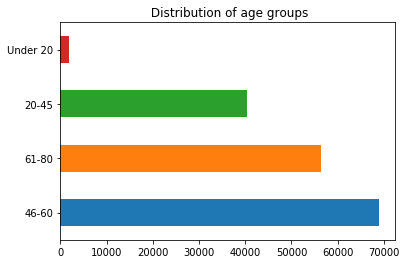

In [54]:
merged_df['Age_Group'].value_counts().plot.barh(title=' Distribution of age groups')

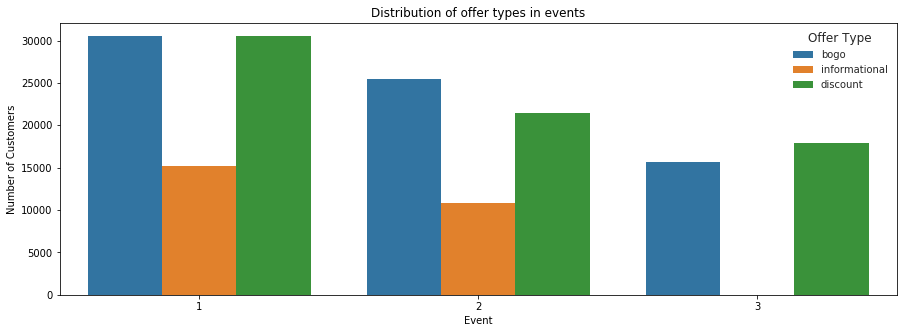

In [55]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "offer_type", data=merged_df)
sns.set(style="darkgrid")
plt.title('Distribution of offer types in events')
plt.ylabel('Number of Customers')
plt.xlabel('Event')
plt.legend(title='Offer Type')

Let's now try to answer the question above and see which age group seems to take advantage of the offers most. Because the number of customers in each group is majorly unbalanced, we'll want to normalize so that we can more accurately compare the age groups

##### Event Key: #

1 = Offer Received

2 = Offer Viewed

3 = Offer Completed/Used

4 = Transaction


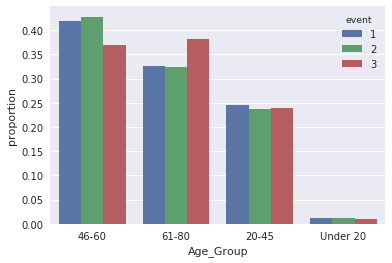

In [56]:
x, y, hue = "Age_Group", "proportion", "event"

(merged_df[x]
 .groupby(merged_df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

Looks like both the 46-60 and 61-80 age groups have the most customers actually fulfilling the offers. Let's take both of the groups and try to understand which offers they actually took advantage of

## Question 2: Of the age group(s) that completed offers, which offers did they take most advantage of?

In [57]:
q2 = merged_df[((merged_df['Age_Group'] == '46-60') | (merged_df['Age_Group'] == '61-80')) & (merged_df['event'] == 3)]

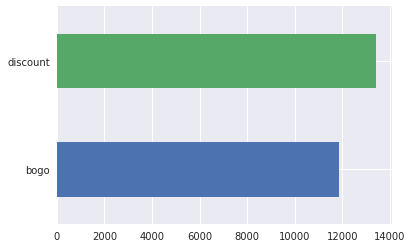

In [58]:
# offer type distribution
q2.offer_type.value_counts().sort_values().plot(kind = 'barh')

Looks like it's a close call, but most of the completed offers were discounts. Let's also look at the male/female distribution of all people who completed offers

## Question 3: How many males vs females took action on offers?

In [59]:
q3 = merged_df[merged_df['event'] == 3]

In [60]:
merged_df.head()

,channels,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward,email,mobile,social,web,...,informational,event,customer_id,time,amount,reward,became_member_on,customer_gender,customer_income,Age_Group
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,...,0,1,4b0da7e80e5945209a1fdddfe813dbe0,0,NaN,NaN,2017-09-09,M,100000.0,61-80
1,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,...,0,2,4b0da7e80e5945209a1fdddfe813dbe0,102,NaN,NaN,2017-09-09,M,100000.0,61-80
2,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,...,0,1,4b0da7e80e5945209a1fdddfe813dbe0,504,NaN,NaN,2017-09-09,M,100000.0,61-80
3,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,...,0,2,4b0da7e80e5945209a1fdddfe813dbe0,510,NaN,NaN,2017-09-09,M,100000.0,61-80
4,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,...,0,3,4b0da7e80e5945209a1fdddfe813dbe0,510,NaN,10.0,2017-09-09,M,100000.0,61-80


First, I really need to know. Do more males or females go to Starbucks?

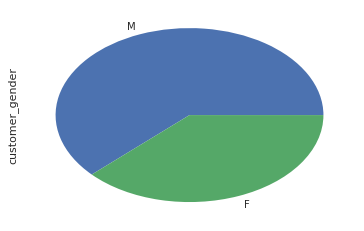

In [61]:
merged_df.customer_gender.value_counts().plot(kind='pie')

Ah! So more males like to go to Starbucks! A lot of people would have argued the opposite

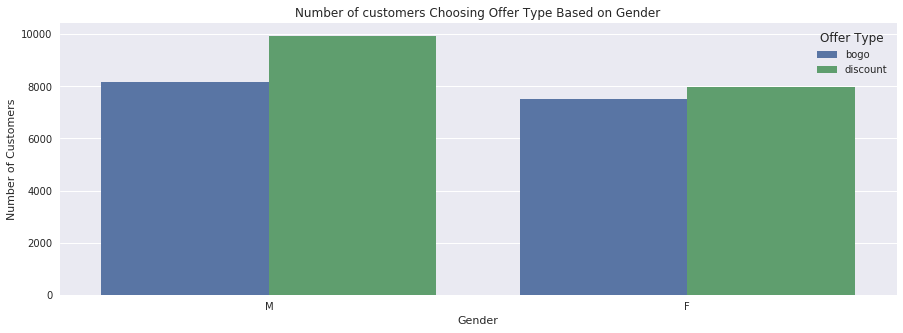

In [62]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "customer_gender", hue= "offer_type", data=q3)
sns.set(style="darkgrid")
plt.title('Number of customers Choosing Offer Type Based on Gender')
plt.ylabel('Number of Customers')
plt.xlabel('Gender')
plt.legend(title='Offer Type')

Looks like both males and females take more advantage of the discounted offers.


## Question 4: What channels are most likely to lead customers to complete offers?

##### Key:

1 = Offer Received

2 = Offer Viewed

3 = Offer Completed/Used

4 = Transaction

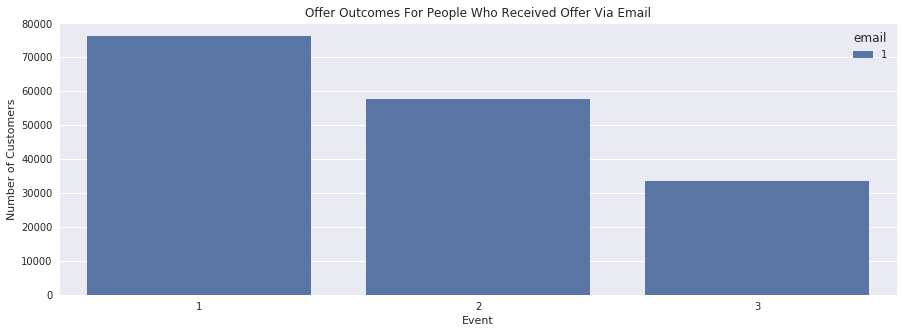

In [63]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "email", data=merged_df[merged_df['email']==1])
sns.set(style="darkgrid")
plt.title('Offer Outcomes For People Who Received Offer Via Email')
plt.ylabel('Number of Customers')
plt.xlabel('Event')
plt.legend(title='email')

Looks like most Starbucks customers manage to claim offers that are communicated via email. 

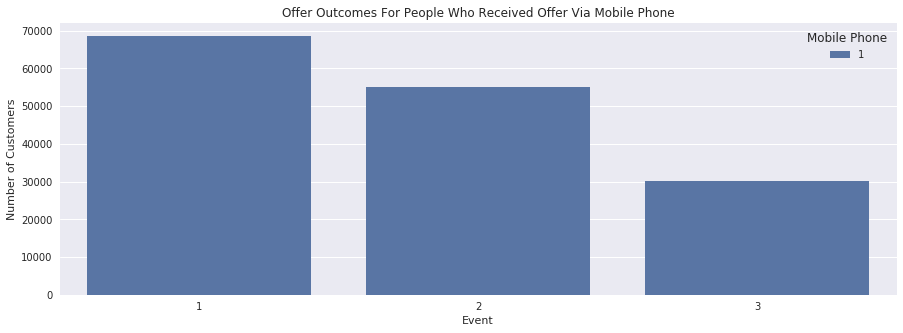

In [64]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "mobile", data=merged_df[merged_df['mobile']==1])
sns.set(style="darkgrid")
plt.title('Offer Outcomes For People Who Received Offer Via Mobile Phone')
plt.ylabel('Number of Customers')
plt.xlabel('Event')
plt.legend(title='Mobile Phone')

It looks like, of all of the communication channels, more people fail to view offers that are sent via mobile phone. It would be interesting to understand how many customers actually use the Starbucks mobile app to make purchases, because Starbucks tends to make offers extremely visible on their app

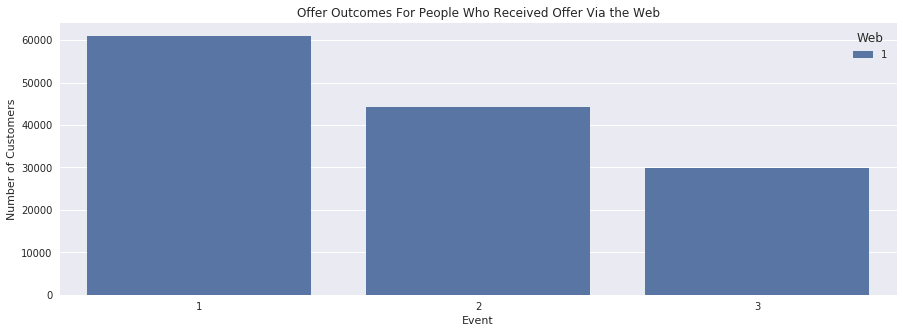

In [65]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "web", data=merged_df[merged_df['web']==1])
sns.set(style="darkgrid")
plt.title('Offer Outcomes For People Who Received Offer Via the Web')
plt.ylabel('Number of Customers')
plt.xlabel('Event')
plt.legend(title='Web')

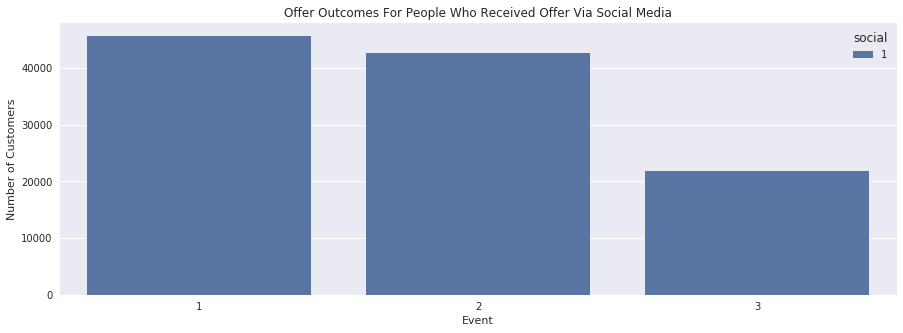

In [66]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "social", data=merged_df[merged_df['social']==1])
sns.set(style="darkgrid")
plt.title('Offer Outcomes For People Who Received Offer Via Social Media')
plt.ylabel('Number of Customers')
plt.xlabel('Event')
plt.legend(title='social')

## Question 5: Are customers influenced by the minimum spend requirement of an offer, or even by the offer amount? Do either of these metrics affect the likelihood that they will use an offer?

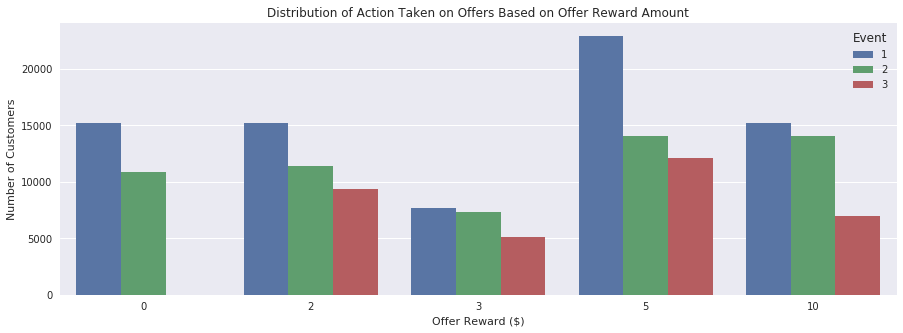

In [67]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "offer_reward", hue= "event", data=merged_df)
sns.set(style="darkgrid")
plt.title('Distribution of Action Taken on Offers Based on Offer Reward Amount')
plt.ylabel('Number of Customers')
plt.xlabel('Offer Reward ($)')
plt.legend(title='Event')

We're seeing more customers claim offers that have higher offer rewards. Makes sense!

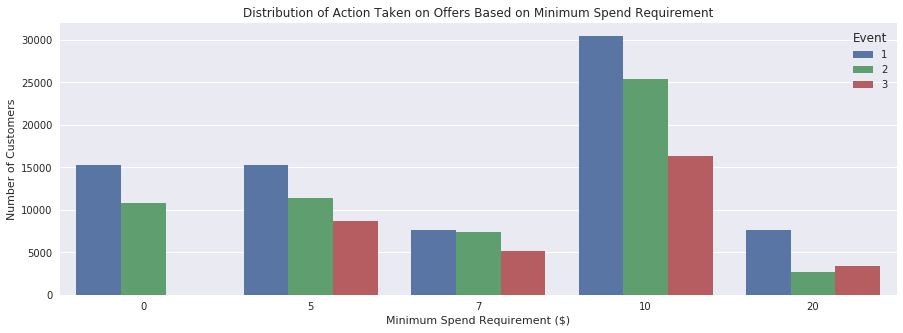

In [68]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "offer_difficulty", hue= "event", data=merged_df)
sns.set(style="darkgrid")
plt.title('Distribution of Action Taken on Offers Based on Minimum Spend Requirement')
plt.ylabel('Number of Customers')
plt.xlabel('Minimum Spend Requirement ($)')
plt.legend(title='Event')

Weird. We would've expected to see fewer people complete offers as offer difficulty increases. It does make sense, however, that more customers aren't viewing the offers as the offer difficulty increases

# Feature Engineering

I just wanted to add one more feature that I thought would be useful to the model

In [69]:
merged_df.columns

Index(['channels', 'offer_difficulty', 'offer_duration', 'offer_id',
       'offer_type', 'offer_reward', 'email', 'mobile', 'social', 'web',
       'bogo', 'discount', 'informational', 'event', 'customer_id', 'time',
       'amount', 'reward', 'became_member_on', 'customer_gender',
       'customer_income', 'Age_Group'],
      dtype='object')

In [70]:
## Calculate number of days since customer became a member
merged_df['became_member_on'] = pd.to_datetime(merged_df['became_member_on'])
merged_df['member_since'] = (datetime.now() - merged_df['became_member_on']).dt.days

In [71]:
merged_df.columns

Index(['channels', 'offer_difficulty', 'offer_duration', 'offer_id',
       'offer_type', 'offer_reward', 'email', 'mobile', 'social', 'web',
       'bogo', 'discount', 'informational', 'event', 'customer_id', 'time',
       'amount', 'reward', 'became_member_on', 'customer_gender',
       'customer_income', 'Age_Group', 'member_since'],
      dtype='object')

# Modeling

Build a Machine Learning model to predict response of a customer to an offer


We'll be playing with 4 different classifiers:
1. KNN Classifier
2. Random Forest Classifier
3. Decision Tree Classifier

To improve upon the Random Forest Classifier, I'll be implementing an additional GridSearch approach with some specified parameters.


### Functions

In [72]:
def clean_data(df):
    '''
    clean_data()
    Purpose: Removes some columns that are useless for modeling
    Inputs:
    - df: the dataframe to clean up
    Returns:
    - The same dataframe, minus the columns that were dropped
    '''
    # One hot encode categorical variables
    age_group_exploded = pd.get_dummies(df['Age_Group'].apply(pd.Series).stack()).sum(level=0)
    df = pd.concat([df, age_group_exploded], axis=1)
    
    gender_exploded = pd.get_dummies(df['customer_gender'].apply(pd.Series).stack()).sum(level=0)
    df = pd.concat([df, gender_exploded], axis=1)
    
    # impute remainin NaNs with 0
    df.fillna(0 , inplace=True)
    
    # remove useless columns
    cols_to_drop = ['offer_id', 'customer_id', 'channels', 'became_member_on', 'offer_type', 'Age_Group', 'customer_gender']
    cleaned_data = df.drop(cols_to_drop, axis=1)
    
    # Normalize data using MinMaxScaler, which normalizes datapoints between 0 and 1
    scaler = MinMaxScaler()
    numerical = ['customer_income', 'offer_difficulty', 'offer_duration', 'offer_reward', 'member_since', 'amount', 'reward', 'time']
    cleaned_data[numerical] = scaler.fit_transform(cleaned_data[numerical])
    
    features = cleaned_data.drop('event', axis=1)
    label = cleaned_data['event']
    
    return features, label

In [73]:
def prepare_data(features,label):
    '''
    prepare_data()
    Purpose: Splits data into train and test datasets
    Inputs:
    - features: a df of all of the features
    - label: a df of all of the labels
    
    Returns:X_train, X_test, y_train and y_test dataframes
    '''
    
    # split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.20, random_state=40)
    
    print("Training set: {} rows".format(X_train.shape[0]))
    print("Testing set: {} rows".format(X_test.shape[0]))
    
    return X_train, X_test, y_train, y_test

In [74]:
def build_model(classifier, gridsearch_yn):
    """
        build_model()
        Purpose: Creates a model pipeline
        Inputs: 
                - classifier: the name of the classifier
                - gridsearch_yn: a boolean indicating whether or not to employ gridsearch
        Returns: A model pipeline
        TODO: Make this a little more generalizable in the future
    """
            
    if classifier == 'DecisionTreeClassifier':
        model = DecisionTreeClassifier(random_state = 40)
    
    elif classifier == 'RandomForestClassifier' or classifier == 'RandomForestClassifier_w_GridSearch':
        if gridsearch_yn:
            pipeline = Pipeline([
            ('clf', RandomForestClassifier())
            ])

            parameters = {
            'clf__n_estimators': [50, 100, 200],
            'clf__min_samples_split': [3, 4]
            }

            model = GridSearchCV(pipeline, param_grid=parameters, verbose=10)
        else:
            model = RandomForestClassifier(random_state = 40)
    
    elif classifier == 'KNeighborsClassifier':
        model = KNeighborsClassifier(n_neighbors = 5)
    
    return model

In [75]:
def train_test_model(clf):
    """
    train_test_model()
    Purpose: Trains, Tests, and evaluates a model
    Inputs: a classifier
    Returns: a train F1 score, a test F1 score  
    """
    train_prediction =  (clf.fit(X_train, y_train)).predict(X_train)
    test_predictions = (clf.fit(X_train, y_train)).predict(X_test)
    train_f1 =  accuracy_score(y_train, train_prediction)*100
    test_f1= fbeta_score(y_test, test_predictions, beta = 0.5, average='micro' )*100
    
    return train_f1, test_f1

### Implementation

In [76]:
print("Cleaning Data...")
try:
    features, label = clean_data(merged_df)
    print("Cleaning Successful!")
except:
    print("Clean Failed.")

Cleaning Data...
Cleaning Successful!


In [77]:
print("Pre-Processing Data...")
try:
    X_train, X_test, y_train, y_test = prepare_data(features, label)
    print("Pre-Processing Successful!")
except:
    print("Pre-Processing Failed.")

Pre-Processing Data...
Training set: 134064 rows
Testing set: 33517 rows
Pre-Processing Successful!


In [78]:
classifiers = {'DecisionTreeClassifier': False, 'KNeighborsClassifier': False, 'RandomForestClassifier': False, 'RandomForestClassifier_w_GridSearch': True}
models = {'model_name': [], 'train_f1_score': [], 'test_f1_score': []}

for clf_name, gridsearch_yn in classifiers.items():
    print("Building {} Model...".format(clf_name))
    try:
        model = build_model(clf_name, gridsearch_yn)
        print("Build Successful!")
    except:
        print("Build Failed.")
        continue
        
    print("Training {} Model...".format(clf_name))
    try:
        train_f1, test_f1 = train_test_model(model)
        
        # append to models dict for comparison later
        if gridsearch_yn:
            models['model_name'].append(clf_name + ' w/ GridSearch CV')
        else:
            models['model_name'].append(clf_name)
            
        models['train_f1_score'].append(train_f1)
        models['test_f1_score'].append(test_f1)
        
        print("Training Successful!")
    except:
        print("Training Failed.")
        continue
            
    print('---------------------------------')
    
model_comp = pd.DataFrame(models)

Building DecisionTreeClassifier Model...
Build Successful!
Training DecisionTreeClassifier Model...
Training Successful!
---------------------------------
Building KNeighborsClassifier Model...
Build Successful!
Training KNeighborsClassifier Model...
Training Successful!
---------------------------------
Building RandomForestClassifier Model...
Build Successful!
Training RandomForestClassifier Model...
Training Successful!
---------------------------------
Building RandomForestClassifier_w_GridSearch Model...
Build Successful!
Training RandomForestClassifier_w_GridSearch Model...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] clf__min_samples_split=3, clf__n_estimators=50 ..................
[CV]  clf__min_samples_split=3, clf__n_estimators=50, score=0.787218331132941, total=   7.2s
[CV] clf__min_samples_split=3, clf__n_estimators=50 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s remaining:    0.0s


[CV]  clf__min_samples_split=3, clf__n_estimators=50, score=0.7940834228428213, total=   6.9s
[CV] clf__min_samples_split=3, clf__n_estimators=50 ..................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.8s remaining:    0.0s


[CV]  clf__min_samples_split=3, clf__n_estimators=50, score=0.7840759057443999, total=   6.8s
[CV] clf__min_samples_split=3, clf__n_estimators=100 .................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.0s remaining:    0.0s


[CV]  clf__min_samples_split=3, clf__n_estimators=100, score=0.7978249681129584, total=  13.4s
[CV] clf__min_samples_split=3, clf__n_estimators=100 .................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   41.1s remaining:    0.0s


[CV]  clf__min_samples_split=3, clf__n_estimators=100, score=0.7975742928750448, total=  12.9s
[CV] clf__min_samples_split=3, clf__n_estimators=100 .................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   56.7s remaining:    0.0s


[CV]  clf__min_samples_split=3, clf__n_estimators=100, score=0.7986662787835388, total=  13.9s
[CV] clf__min_samples_split=3, clf__n_estimators=200 .................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.2min remaining:    0.0s


[CV]  clf__min_samples_split=3, clf__n_estimators=200, score=0.7928125489494059, total=  27.7s
[CV] clf__min_samples_split=3, clf__n_estimators=200 .................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.8min remaining:    0.0s


[CV]  clf__min_samples_split=3, clf__n_estimators=200, score=0.796030254206946, total=  27.3s
[CV] clf__min_samples_split=3, clf__n_estimators=200 .................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.3min remaining:    0.0s


[CV]  clf__min_samples_split=3, clf__n_estimators=200, score=0.795443865106183, total=  27.4s
[CV] clf__min_samples_split=4, clf__n_estimators=50 ..................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.9min remaining:    0.0s


[CV]  clf__min_samples_split=4, clf__n_estimators=50, score=0.7992123341314418, total=   6.7s
[CV] clf__min_samples_split=4, clf__n_estimators=50 ..................
[CV]  clf__min_samples_split=4, clf__n_estimators=50, score=0.7940834228428213, total=   6.9s
[CV] clf__min_samples_split=4, clf__n_estimators=50 ..................
[CV]  clf__min_samples_split=4, clf__n_estimators=50, score=0.8073041376686733, total=   6.6s
[CV] clf__min_samples_split=4, clf__n_estimators=100 .................
[CV]  clf__min_samples_split=4, clf__n_estimators=100, score=0.8068428472330998, total=  13.3s
[CV] clf__min_samples_split=4, clf__n_estimators=100 .................
[CV]  clf__min_samples_split=4, clf__n_estimators=100, score=0.8104412817758683, total=  13.2s
[CV] clf__min_samples_split=4, clf__n_estimators=100 .................
[CV]  clf__min_samples_split=4, clf__n_estimators=100, score=0.8024705171526395, total=  13.8s
[CV] clf__min_samples_split=4, clf__n_estimators=200 .................
[CV]  c

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  5.7min finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] clf__min_samples_split=3, clf__n_estimators=50 ..................
[CV]  clf__min_samples_split=3, clf__n_estimators=50, score=0.7976235762715657, total=   6.8s
[CV] clf__min_samples_split=3, clf__n_estimators=50 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.1s remaining:    0.0s


[CV]  clf__min_samples_split=3, clf__n_estimators=50, score=0.7918456856426781, total=   6.6s
[CV] clf__min_samples_split=3, clf__n_estimators=50 ..................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.1s remaining:    0.0s


[CV]  clf__min_samples_split=3, clf__n_estimators=50, score=0.799270481348043, total=   6.8s
[CV] clf__min_samples_split=3, clf__n_estimators=100 .................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.3s remaining:    0.0s


[CV]  clf__min_samples_split=3, clf__n_estimators=100, score=0.7892770032894001, total=  14.0s
[CV] clf__min_samples_split=3, clf__n_estimators=100 .................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   41.0s remaining:    0.0s


[CV]  clf__min_samples_split=3, clf__n_estimators=100, score=0.7939267812388113, total=  13.8s
[CV] clf__min_samples_split=3, clf__n_estimators=100 .................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   57.4s remaining:    0.0s


[CV]  clf__min_samples_split=3, clf__n_estimators=100, score=0.7988005460200953, total=  13.7s
[CV] clf__min_samples_split=3, clf__n_estimators=200 .................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.2min remaining:    0.0s


[CV]  clf__min_samples_split=3, clf__n_estimators=200, score=0.7926782877218107, total=  28.1s
[CV] clf__min_samples_split=3, clf__n_estimators=200 .................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.8min remaining:    0.0s


[CV]  clf__min_samples_split=3, clf__n_estimators=200, score=0.7922932330827067, total=  27.7s
[CV] clf__min_samples_split=3, clf__n_estimators=200 .................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.3min remaining:    0.0s


[CV]  clf__min_samples_split=3, clf__n_estimators=200, score=0.796898426835545, total=  28.0s
[CV] clf__min_samples_split=4, clf__n_estimators=50 ..................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.9min remaining:    0.0s


[CV]  clf__min_samples_split=4, clf__n_estimators=50, score=0.7944460605518137, total=   6.9s
[CV] clf__min_samples_split=4, clf__n_estimators=50 ..................
[CV]  clf__min_samples_split=4, clf__n_estimators=50, score=0.79468761188686, total=   6.7s
[CV] clf__min_samples_split=4, clf__n_estimators=50 ..................
[CV]  clf__min_samples_split=4, clf__n_estimators=50, score=0.8034103878085349, total=   6.9s
[CV] clf__min_samples_split=4, clf__n_estimators=100 .................
[CV]  clf__min_samples_split=4, clf__n_estimators=100, score=0.8002640470809371, total=  13.6s
[CV] clf__min_samples_split=4, clf__n_estimators=100 .................
[CV]  clf__min_samples_split=4, clf__n_estimators=100, score=0.799812030075188, total=  13.7s
[CV] clf__min_samples_split=4, clf__n_estimators=100 .................
[CV]  clf__min_samples_split=4, clf__n_estimators=100, score=0.8074831606507485, total=  13.7s
[CV] clf__min_samples_split=4, clf__n_estimators=200 .................
[CV]  clf_

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  5.7min finished


Training Successful!
---------------------------------


In [79]:
model_comp

,model_name,train_f1_score,test_f1_score
0,DecisionTreeClassifier,93.925289,84.900200
1,KNeighborsClassifier,78.699726,63.898917
2,RandomForestClassifier,93.256206,73.362771
3,RandomForestClassifier_w_GridSearch w/ GridSea...,93.754475,79.058388


Of the four classifier variations tested, it looks like the Decision Tree classifier performs the best, with an F1 Validation score of 84.9. The RandomForestClassifier also performs very well, and it also makes sense that the RFC with GridSearch performs better than the one without. Because the problem that we’re trying to solve isn’t very high stakes, a moderate F1 score is sufficient enough for us to classify whether a customer will respond to an offer or not.

In [80]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Starbucks_Capstone_Notebook.ipynb'])

255

fin